# Goal: 
## Predict the outcome of a game based on what heroes have been picked 

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import requests
from bs4 import BeautifulSoup
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('dota_games.txt', sep=",", header=None, names=["Sentinal_1", "Sentinal_2", 
                                                                "Sentinal_3", "Sentinal_4", "Sentinal_5",
                                                                "Scourge_1", "Scourge_2", "Scourge_3", 
                                                                "Scourge_4", "Scourge_5", "Won"])
df.head(8)

,Sentinal_1,Sentinal_2,Sentinal_3,Sentinal_4,Sentinal_5,Scourge_1,Scourge_2,Scourge_3,Scourge_4,Scourge_5,Won
0,Sven,Lone Druid,Venomancer,Clockwerk,Shadow Shaman,Invoker,Gyrocopter,Anti-Mage,Alchemist,Slark,2
1,Riki,Tinker,Puck,Leshrac,Nyx Assassin,Slardar,Sand King,Spectre,Necrolyte,Warlock,1
2,Invoker,Mirana,Pudge,Magnus,Keeper of the Light,Rubick,Tidehunter,Queen of Pain,Faceless Void,Sniper,2
3,Riki,Centaur Warrunner,Treant Protector,Queen of Pain,Broodmother,Rubick,Weaver,Troll Warlord,Alchemist,Drow Ranger,1
4,Razor,Kunkka,Drow Ranger,Leshrac,Zeus,Riki,Bane,Visage,Invoker,Timbersaw,1
5,Sand King,Shadow Shaman,Silencer,Gyrocopter,Meepo,Nyx Assassin,Slark,Mirana,Rubick,Queen of Pain,2
6,Morphling,Omniknight,Pudge,Crystal Maiden,Razor,Troll Warlord,Tidehunter,Lina,Dark Seer,Gyrocopter,1
7,Brewmaster,Leshrac,Ogre Magi,Kunkka,Riki,Disruptor,Juggernaut,Tiny,Enigma,Bounty Hunter,1


In [3]:
# check for fragmented data
df.isnull().any()

Sentinal_1    False
Sentinal_2    False
Sentinal_3    False
Sentinal_4    False
Sentinal_5    False
Scourge_1     False
Scourge_2     False
Scourge_3     False
Scourge_4     False
Scourge_5     False
Won           False
dtype: bool

In [4]:
# create a new df with all the winning teams lineups
sentinal_df = df[['Sentinal_1','Sentinal_2','Sentinal_3','Sentinal_4','Sentinal_5','Won']]
sentinal_winners = sentinal_df[df.Won == 1]
sentinal_winners.rename(columns={'Sentinal_1': "Hero_1", 'Sentinal_2': "Hero_2", 
                               'Sentinal_3': "Hero_3", 'Sentinal_4': "Hero_4",
                               'Sentinal_5': "Hero_5"}, inplace=True)

scourge_df = df[['Scourge_1','Scourge_2','Scourge_3','Scourge_4','Scourge_5','Won']]
scourge_winners = scourge_df[df.Won == 2]
scourge_winners['Won'] = 1
scourge_winners.rename(columns={'Scourge_1': "Hero_1", 'Scourge_2': "Hero_2", 
                               'Scourge_3': "Hero_3", 'Scourge_4': "Hero_4",
                               'Scourge_5': "Hero_5"}, inplace=True)

# create a new df for the losing teams

sentinal_losers = sentinal_df[df.Won == 2]
sentinal_losers['Won'] = 0
sentinal_losers.rename(columns={'Sentinal_1': "Hero_1", 'Sentinal_2': "Hero_2", 
                               'Sentinal_3': "Hero_3", 'Sentinal_4': "Hero_4",
                               'Sentinal_5': "Hero_5"}, inplace=True)

scourge_losers = scourge_df[df.Won == 1]
scourge_losers['Won'] = 0
scourge_losers.rename(columns={'Scourge_1': "Hero_1", 'Scourge_2': "Hero_2", 
                               'Scourge_3': "Hero_3", 'Scourge_4': "Hero_4",
                               'Scourge_5': "Hero_5"}, inplace=True)

# merge the dataframes to create a df that contains all the lineups and if they won or not
lineups = pd.concat([sentinal_winners, scourge_winners, sentinal_losers, scourge_losers])
lineups.reset_index(drop=True, inplace=True)
lineups.head()

D:\Programs\Anaconda\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,Hero_1,Hero_2,Hero_3,Hero_4,Hero_5,Won
0,Riki,Tinker,Puck,Leshrac,Nyx Assassin,1
1,Riki,Centaur Warrunner,Treant Protector,Queen of Pain,Broodmother,1
2,Razor,Kunkka,Drow Ranger,Leshrac,Zeus,1
3,Morphling,Omniknight,Pudge,Crystal Maiden,Razor,1
4,Brewmaster,Leshrac,Ogre Magi,Kunkka,Riki,1


In [5]:
# split the hero list from the outcome of the game
features_df = lineups.drop('Won', axis=1)
# features_df.head()

def populate_df(df):
    uniques = pd.unique(df.values.ravel('K'))
    zeros = np.zeros(len(uniques))
    
    
    all_dummies = []
    for row in df.itertuples():
        i = 1
        uniques_dic = dict(zip(uniques, zeros))
        while i < 6:
            uniques_dic[row[i]] = 1
            i += 1
            
        all_dummies.append(uniques_dic)       
    return pd.DataFrame(all_dummies, columns=uniques)

dummies_df = populate_df(features_df)
no_features_df = pd.concat([dummies_df, lineups.Won], axis=1)
# dummies_csv = no_features_df.to_csv (r'C:\Users\GILOR\Desktop\data_science\Flatiron_projects\Dota_Victory_Classification\dota2_dummies.csv', 
#                                  index = None, header=True)

D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


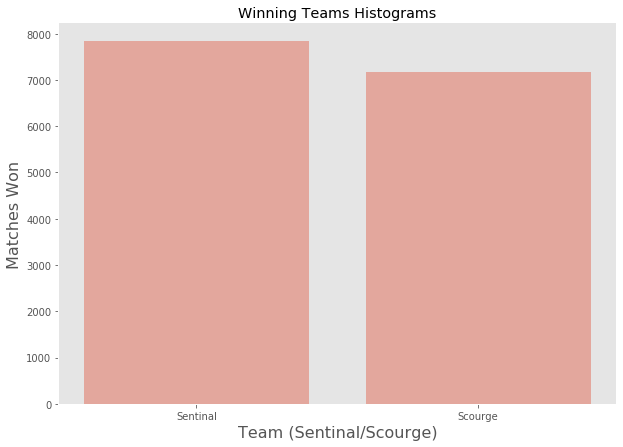

In [6]:
# check for class imbalance
outcome_df = pd.get_dummies(lineups.Won)
outcome_df = outcome_df.rename(columns={0:'Sentinal', 1: 'Scourge'})
sum_wins_by_team = pd.concat([dummies_df, outcome_df], axis=1)

sum_wins_by_team = sum_wins_by_team.groupby(['Sentinal', 'Scourge']).sum()
sum_wins_by_team.reset_index(inplace=True)

sum_wins_by_team['Sentinal'][1] = len(sentinal_winners)
sum_wins_by_team['Sentinal'][0] = (15000 - len(sentinal_winners))
sum_wins_by_team.drop('Scourge', axis=1, inplace=True)


plt.figure(figsize=(10, 7))  

# Remove the plot frame lines. 
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  

# set labels
plt.title("Winning Teams Histograms")
plt.xlabel("Team (Sentinal/Scourge)", fontsize=16)  
plt.ylabel("Matches Won", fontsize=16)  


# Plot the bar chat to show how many times each team won 
plt.bar(['Sentinal', 'Scourge'], [len(sentinal_winners), (15000-len(sentinal_winners))], alpha=0.4)
plt.grid(b=None)
plt.show()

In [7]:
def character_by_attributes(attribute):
    '''This function scrapes all of the heroes by their main attribute
       off of dota2 wikisite'''
    # Make a get request to retrieve the page
    html = requests.get(f'https://dota2.gamepedia.com/{attribute}') 

    # Pass the page contents to beautiful soup for parsing
    soup = BeautifulSoup(html.content, 'html.parser')

    # search for the characters by attribute
    char_raw = soup.findAll('td',{'style':"white-space:nowrap;"})
    char_list = np.array([item.find('a').attrs['href'].replace('/', '') for item in char_raw])
    return char_list

In [8]:
# Sort characters based on their main attribute (Strength, Agility, Intellegence)
str_heroes = character_by_attributes('Strength')
agi_heroes = character_by_attributes('Agility')
int_heroes = character_by_attributes('Intelligence')
agi_heroes = [x.replace('_', ' ') for x in agi_heroes]
int_heroes = [x.replace('_', ' ') for x in int_heroes]
int_heroes = [x.replace('%27', "'") for x in int_heroes]

In [9]:
# create a new feature: how many strength heros
str_df = features_df.where(~features_df.isin(str_heroes), None)
str_df = pd.DataFrame(str_df.isnull().sum(axis=1), columns=['Strength'])
str_df = str_df / 5
# str_df.head()

In [10]:
# create a new feature: how many agility heros
agi_df = features_df.where(~features_df.isin(agi_heroes), None)
agi_df = pd.DataFrame(agi_df.isnull().sum(axis=1), columns=['Agility'])
agi_df = agi_df / 5
# agi_df.head()

In [11]:
# create a new feature: how many inteligence heros
int_df = features_df.where(~features_df.isin(int_heroes), None)
int_df = pd.DataFrame(int_df.isnull().sum(axis=1), columns=['Intelligence'])
int_df = int_df / 5
# int_df.head()

In [12]:
# ranged heros
ranged = np.array(['Techies', 'Ancient Apparition', 'Lina', 'Chen', 'Enchantress', 
                   'Mirana', 'Pugna', 'Arc Warden', 'Disruptor', 'Drow Ranger', 
                   'Skywrath Mage', 'Oracle', 'Crystal Maiden', 'Death Prophet', 'Invoker', 
                   'Keeper of the Light', 'Leshrac', 'Lion', 'Medusa', "Nature's Prophet", 
                   'Silencer', 'Visage', 'Warlock', 'Windrunner', 'Witch Doctor',  'Clinkz', 
                   'Viper', 'Dazzle', 'Lich', 'Lone Druid', 'Puck', 'Queen of Pain', 'Rubick', 
                   'Sniper', 'Enigma', 'Wisp', 'Necrophos', 'Phoenix', 'Shadow Demon', 
                   'Shadow Fiend', 'Tinker', 'Troll Warlord', 'Storm Spirit', 'Razor', 
                   'Outworld Devourer', 'Venomancer', 'Weaver', 'Winter Wyvern', 'Bane', 
                   'Huskar', 'Jakiro', 'Shadow Shaman', 'Vengeful Spirit', 'Zeus', 'Batrider', 
                   'Gyrocopter', 'Morphling', 'Luna'])
# create a new feature: how many melee heros in the team
melee_df = features_df.where(~features_df.isin(ranged), None)
melee_df = pd.DataFrame(melee_df.isnull().sum(axis=1), columns=['Ranged'])
melee_df = melee_df / 5

# melee_df.tail()

In [13]:
# tier  list
tier1 = np.array(['Alchemist', 'Enchan', 'Lifestealer', 'Visage',
                 'Wisp', 'Outerworld Devourer', 'Weaver',
                 "Nature's Prophet", 'Rubick'])

tier2 = np.array(['Nyx Assassin', 'Gyrocopter', 
                  'Alchemist', 'Puck', 'Chen'])

tier3 = np.array(['Shadow Demon', 'Lone Druid', 'Clockwerk', 'Queen of Pain',
                  'Dragon Knight', 'Treant Protector', 'Keeper of the Light'
                  'Bane', 'Jakiro', 'Anti-Mage', 'Timbersaw', 'Storm Spirit',
                  'Razor', 'Enchantress', 'Bounty Hunter', 'Templar Assassin',
                  'Abaddon', 'Crystal Maiden', 'Windrunner', 'Magnus', 
                  'Shadow Fiend', 'Leshrac'])

# create a new feature: how many characters are tier 1,2 or 3
op_tiers12_df = features_df.where(~features_df.isin(tier1) & ~features_df.isin(tier2), None)
op_tiers12_df = pd.DataFrame(op_tiers12_df.isnull().sum(axis=1), columns=['Tiers_12'])
op_tiers12_df = op_tiers12_df / 5
# op_tiers12_df.head()

op_tiers3_df = features_df.where(~features_df.isin(tier3), None)
op_tiers3_df = pd.DataFrame(op_tiers3_df.isnull().sum(axis=1), columns=['Tier_3'])
op_tiers3_df = op_tiers3_df / 5
# op_tiers3_df.head()

In [14]:
# Safe lane carry characters
carry = np.array(['Alchemist', 'Anti-Mage', 'Arc Warden', 'Bloodseeker', 'Clinkz'
                  'Chaos Knight', 'Drow Ranger', 'Faceless Void', 'Gyrocopter',
                  'Huskar', 'Juggernaut', 'Kunkka', 'Lifestealer', 'Lone Druid',
                  'Luna', 'Lycan' 'Medusa', 'Meepo', 'Morphling', 'Naga Siren',
                  'Phantom Assassin', 'Phantom Lancer', 'Slark', 'Spectre',
                  'Sven', 'Terrorblade', 'Timbersaw', 'Troll Warlord', 'Tiny',
                  'Ursa', 'Vengeful Spirit', 'Venomancer', 'Viper', 'Weaver'])

# create new feature: amount of carry character in a team
carry_df = features_df.where(~features_df.isin(carry), None)
carry_df = pd.DataFrame(carry_df.isnull().sum(axis=1), columns=['Carry']) 
carry_df = carry_df / 5
# carry_df.head()

In [15]:
# support characters
support = np.array(['Ancient Apparition', 'Bristleback', 'Clockwerk', 'Chen',
                    'Bane', 'Crystal Maiden', 'Dazzle', 'Disruptor', 'Doom',
                    'Earthshaker', 'Enchantress', 'Wisp', 'Jakiro', 'Leshrac'
                    'Keeper of the Light', 'Lich', 'Lina', 'Lion', 'Nyx Assassin',
                    'Ogre Magi', 'Omniknight', 'Oracle', 'Phoenix', 'Rubick',
                    'Shadow Demon', 'Shadow Shaman', 'Silencer', 'Treant Protector',
                    'Undying', 'Visage', 'Warlock', 'Weaver', 'Windrunner', 'Winter Wyvern',
                    'Witch Doctor', 'Oracle'])

# create new feature: amount of support characters in a team
support_df = features_df.where(~features_df.isin(support), None)
support_df = pd.DataFrame(support_df.isnull().sum(axis=1), columns=['Support'])
support_df = support_df / 5
# support_df.head()

In [16]:
#offlane characters
offlane = np.array(['Abaddon', 'Axe', 'Batrider', 'Beasmaster',
                    'Brewmaster', 'Bristleback', 'Broodmother',
                    'Centaur Warrunner', 'Clockwerk', 'Dark Seer',
                    'Doom', 'Earthshaker', 'Enchantress', 'Enigma',
                    'Legion Commander', 'Magnus', "Nature's Prophet",
                    'Night Stalker', 'Nyx Assassin', 'Puck',
                    'Sand King', 'Slardar', 'Spirit Breaker', 
                    'Tidehunter', 'Undying', 'Underlord'])

# create new feature: amount of offlane characters in a team
offlane_df = features_df.where(~features_df.isin(offlane), None)
offlane_df = pd.DataFrame(offlane_df.isnull().sum(axis=1), columns=['Offlane'])
offlane_df = offlane_df / 5
offlane_df.head()

,Offlane
0,0.4
1,0.4
2,0.0
3,0.0
4,0.2


In [18]:
# middle lane characters
mid = np.array(['Alchemist', 'Arc Warden', 'Bloodseeker', 'Bristleback',
                'Broodmother', 'Death Prophet', 'Dragon Knight', 'Ember Spirit',
                'Faceless Void', 'Invoker', 'Wisp', 'Juggernaut',
                'Lina', 'Leshrac', 'Lone Druid', 'Magnus', 'Medusa', 'Meepo',
                'Mirana', "Nature's Prophet", 'Necrophos', 'Outworld Devourer',
                'Puck', 'Pugna', 'Queen of Pain', 'Razor', 'Shadow Fiend','Zeus' 
                'Skywrath Mage', 'Sniper', 'Storm Spirit', 'Templar Assassin',
                'Tinker', 'Tiny', 'Venomancer', 'Viper', 'Visage', 'Windrunner'])

# create new feature: how many mid lane appropriate characters
mid_df = features_df.where(~features_df.isin(mid), None)
mid_df = pd.DataFrame(mid_df.isnull().sum(axis=1), columns=['Mid'])
mid_df = mid_df /5
# mid_df.head()

In [19]:
# roaming support characters
roaming_support = np.array(['Bounty Hunter', 'Earth Spirit', 'Mirana', "Nature's Prophet",
                            'Pudge', 'Riki', 'Tusk', 'Techies', 'Spirit Breaker', 'Bane'
                            'Night Stalker', 'Windrunner', 'Lion', 'Earthshaker', 'Rubick'])

# create new feature: how many roaming characters
roam_df = features_df.where(~features_df.isin(roaming_support), None)
roam_df = pd.DataFrame(roam_df.isnull().sum(axis=1), columns=['Roamer'])
roam_df = roam_df / 5
# roam_df.head()

In [20]:
# nuke/disable characters
nuke_disable = np.array(['Crystal Maiden', 'Lina', 'Lion', 'Oracle', 'Skywrath Mage', 'Witch Doctor',
                         'Earthshaker', 'Death Prophet', 'Lich', 'Ancient Apparition', 'Shadow Shaman',
                         'Puck', 'Jakiro', 'Necrophos', 'Leshrac', 'Disruptor', 'Outworld Devourer',
                         'Bane', 'Ogre Magi', 'Zeus', 'Doom', 'Dazzle', 'Morphling', 'Nyx Assassin',
                         'Rubick', 'Queen of Pain', 'Tinker'])

# create new feature: how many nukers/disablers in team
nuke_disable_df = features_df.where(~features_df.isin(nuke_disable), None)
nuke_disable_df = pd.DataFrame(nuke_disable_df.isnull().sum(axis=1), columns=['Nuke/Disable'])
nuke_disable_df = nuke_disable_df / 5
# nuke_disable_df.head()

<Figure size 864x576 with 0 Axes>

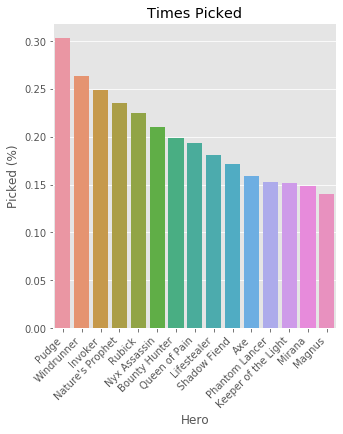

In [21]:
# see which hereos won the most games
sum_wins = pd.DataFrame(dummies_df.sum(), columns=["Winners"])
sum_wins.sort_values(by=['Winners'], ascending=False, inplace=True)

sum_wins = sum_wins[['Winners']].apply(lambda x: x / 15000)
sum_wins.reset_index(inplace=True)
sum_wins.rename(columns={'index':'Hero'}, inplace=True)
top15_wins = sum_wins.head(15)

# plot the top winners
plt.figure(figsize=(12,8))
sns.catplot(kind='bar', data=top15_wins, x='Hero', y='Winners')
plt.title('Times Picked')
plt.ylabel('Picked (%)')
plt.xticks(rotation=45, ha='right')

# create new feature: how many from the characters from the top win rate
top_wins_df = features_df.where(~features_df.isin(top15_wins), None)
top_wins_df = pd.DataFrame(top_wins_df.isnull().sum(axis=1), columns=['Winners'])
# top_wins_df.head()

In [22]:
# # Get the win % for every hero
# outcome_df = pd.get_dummies(lineups.Won)
# outcome_df = outcome_df.rename(columns={0:'Sentinal', 1: 'Scourge'})
# sum_wins_by_team = pd.concat([lineups, outcome_df], axis=1)
# sum_wins_by_team.drop('Won', axis=1, inplace=True)

# sum_wins_by_team = sum_wins_by_team.groupby(['Sentinal', 'Scourge']).sum()
# sum_wins_by_team.reset_index(inplace=True)

# sum_wins_by_team['Sentinal'][1] = len(sentinal_winners)
# sum_wins_by_team['Sentinal'][0] = (15000 - len(sentinal_winners))
# sum_wins_by_team.drop('Scourge', axis=1, inplace=True)

# # sum_sentinal_wins = sum_wins.head(1)
# # sum_scourge_wins = sum_wins.tail(1)


# # sum_sentinal_wins.rename(columns={'Sentinal':'Wins'}, inplace=True)
# # sum_scourge_wins.rename(columns={'Sentinal':'Wins'}, inplace=True)


In [23]:
# 2018 most used characters - patch 7.19
picked_719 = np.array(['Mirana', 'Earthshaker', 'Tiny', 'Necrophos', 'Weaver',
                        'Winter Wyvern', 'Phoenix', 'Lina', 'Bane', 'Phantom Lancer'])

# create new feature: how many from the characters from the top win rate
picked_719_df = features_df.where(~features_df.isin(picked_719), None)
picked_719_df = pd.DataFrame(picked_719_df.isnull().sum(axis=1), columns=['Most_Picked_719'])
picked_719_df = picked_719_df / 5
# picked_719_df.head()

In [24]:
# 2018 most used characters - patch 7.20
picked_720 = np.array(['Rubick', 'Lich', 'Phantom Assassin', 'Brewmaster', 'Centaur Warrunner',
                        'Dazzle', 'Sand King', 'Tusk', 'Terrorblade'])

# create new feature: how many from the characters from the top win rate
picked_720_df = features_df.where(~features_df.isin(picked_720), None)
picked_720_df = pd.DataFrame(picked_720_df.isnull().sum(axis=1), columns=['Most_Picked_720'])
picked_720_df = picked_720_df / 5
# picked_720_df.head()

In [30]:
# concatanate all the features together
cleaned_df = pd.concat([dummies_df, melee_df, str_df, agi_df, int_df, 
                         op_tiers12_df, op_tiers3_df, carry_df, support_df, 
                         offlane_df, mid_df, roam_df, nuke_disable_df, 
                         top_wins_df, picked_719_df, picked_720_df, 
                         lineups['Won']], axis=1)
# scaling the dataset
cols = cleaned_df.columns
scaler = StandardScaler()
scaler.fit(cleaned_df)
scaled_features = scaler.transform(cleaned_df)

scaled_features_df = pd.DataFrame(scaled_features, columns=cols, index=cleaned_df.index)
scaled_features_df.head()

# save the new dataframe as a csv file
# export_csv = cleaned_df.to_csv (r'C:\Users\GILOR\Desktop\data_science\Flatiron_projects\Dota_Victory_Classification\dota2_cleaned.csv', 
#                                  index = None, header=True)

# cleaned_df.tail()

,Riki,Razor,Morphling,Brewmaster,Slardar,Wisp,Omniknight,Slark,Ogre Magi,Chaos Knight,...,Carry,Support,Offlane,Mid,Roamer,Nuke/Disable,Winners,Most_Picked_719,Most_Picked_720,Won
0,5.253443,-0.155243,-0.186940,-0.181034,-0.187513,-0.21094,-0.183669,-0.245093,-0.197112,-0.211026,...,-1.615486,-0.493732,1.007526,1.261730,0.157217,3.185349,0.0,-0.678438,-0.650247,1.0
1,5.253443,-0.155243,-0.186940,-0.181034,-0.187513,-0.21094,-0.183669,-0.245093,-0.197112,-0.211026,...,-1.615486,-0.493732,1.007526,0.266544,0.157217,-0.254635,0.0,-0.678438,1.141562,1.0
2,-0.190351,6.441500,-0.186940,-0.181034,-0.187513,-0.21094,-0.183669,-0.245093,-0.197112,-0.211026,...,0.711521,-1.621490,-1.304373,0.266544,-1.058379,0.892026,0.0,-0.678438,-0.650247,1.0
3,-0.190351,6.441500,5.349299,-0.181034,-0.187513,-0.21094,5.444586,-0.245093,-0.197112,-0.211026,...,-0.451982,0.634025,-1.304373,-0.728642,0.157217,0.892026,0.0,-0.678438,-0.650247,1.0
4,5.253443,-0.155243,-0.186940,5.523822,-0.187513,-0.21094,-0.183669,-0.245093,5.073260,-0.211026,...,-0.451982,-0.493732,-0.148424,-0.728642,0.157217,0.892026,0.0,-0.678438,1.141562,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,-0.190351,-0.155243,5.349299,-0.181034,-0.187513,-0.21094,-0.183669,-0.245093,-0.197112,-0.211026,...,0.711521,-0.493732,-0.148424,-0.728642,1.372813,-0.254635,0.0,-0.678438,-0.650247,-1.0
29996,-0.190351,-0.155243,-0.186940,-0.181034,-0.187513,-0.21094,-0.183669,-0.245093,-0.197112,-0.211026,...,-0.451982,-0.493732,-0.148424,0.266544,2.588409,-0.254635,0.0,2.694918,-0.650247,-1.0
29997,-0.190351,-0.155243,-0.186940,-0.181034,-0.187513,-0.21094,-0.183669,-0.245093,-0.197112,-0.211026,...,-0.451982,1.761783,-1.304373,0.266544,-1.058379,0.892026,0.0,-0.678438,-0.650247,-1.0
29998,-0.190351,-0.155243,-0.186940,-0.181034,-0.187513,-0.21094,-0.183669,-0.245093,-0.197112,-0.211026,...,-0.451982,0.634025,1.007526,-0.728642,0.157217,0.892026,0.0,-0.678438,-0.650247,-1.0


In [ ]:
# test_df = pd.concat([dummies_df, melee_df, str_df, agi_df, int_df, 
#                      carry_df, support_df, offlane_df, mid_df, roam_df, 
#                      nuke_disable_df, top_wins_df, lineups['Won']], axis=1)
# debug_csv = test_df.to_csv (r'C:\Users\GILOR\Desktop\data_science\Flatiron_projects\Dota_Victory_Classification\dota2_debugging.csv', 
#                                  index = None, header=True)

In [ ]:
def create_hist(df, column, save=None):
    plt.figure(figsize=(8, 5))  

    # Remove the plot frame lines. 
    ax = plt.subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    
    # set labels
    plt.title(f"{column} Heroes in Team Histogram")
    plt.xlabel(f"{column} Per Team", fontsize=16)  
    plt.ylabel("Matches Won", fontsize=16)  

    # Plot the histogram  
    plt.hist(df[column], bins=5, alpha=0.7, density=True)
    plt.show()
    if save:
        plt.savefig(f'{column}_Histogram.png')
    pass

In [ ]:
# evaluate how the winning teams were set up
winners_df = cleaned_df.loc[cleaned_df.Won == 1]
for column in winners_df.columns:
    if column not in dummies_df.columns and column != 'Won':
        create_hist(winners_df, column=column)
